Processing image  1 / 8


/tmp/ipykernel_16199/529617569.py:98: UserWarning: ISIC_0076995_a_reduced.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(saveFig + '_a_reduced.png', stats.sides[1].image)
/tmp/ipykernel_16199/529617569.py:99: UserWarning: ISIC_0076995_b_reduced.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(saveFig + '_b_reduced.png', stats.sides[0].image)
/tmp/ipykernel_16199/529617569.py:100: UserWarning: ISIC_0076995_a_flipped_reduced.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(saveFig + '_a_flipped_reduced.png', stats.overlapped.flippedLeft)
/tmp/ipykernel_16199/529617569.py:101: UserWarning: ISIC_0076995_asymmetry_reduced.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please co

Processing image  2 / 8
Processing image  3 / 8
Processing image  4 / 8
Processing image  5 / 8
Processing image  6 / 8
Processing image  7 / 8
Processing image  8 / 8


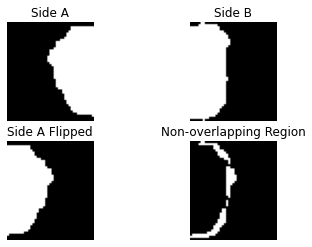

In [4]:
import time
import logging
import csv
from pathlib import Path
from skimage.measure import label, regionprops
from skimage.transform import rotate, rescale
import numpy
from enum import Enum
import math
import os
from os import listdir
import re
from skimage import io
import matplotlib.pyplot as plt
from artifact_removal import remove_hair
from shared import plot_comparison

class LesionFeatures:
  def __init__(self, asymmetryScore):
    self.asymmetry = asymmetryScore
    self.featureNamesList = ['Asymmetry']

  def featuresList(self):
    return [self.asymmetry]

def plotComparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True, sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

def readImage(filename):
    return io.imread(filename)

def getImagesInDir(dir, match = '', limit = -1):
    fullPaths = []
    imageNames = listdir(dir)
    for f in imageNames:
        doesMatch = 0 if not match else re.match(match, f)
        if doesMatch:
            fullPaths.append(os.path.join(os.getcwd(), dir, f))

    if limit > -1:
        fullPaths = fullPaths[0:limit]
    return fullPaths

def plotAsymmetry(stats):
    fig, ax1 = plt.subplots()
    image = stats.image
    region = stats.region
    ax1.imshow(image, cmap=plt.cm.gray)

    y0, x0 = region.centroid
    orientation = region.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * region.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * region.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * region.minor_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * region.minor_axis_length

    ax1.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax1.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax1.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = region.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax1.plot(bx, by, '-b', linewidth=2.5)

    ax1.axis((0, len(stats.image[0]), len(stats.image), 0))

    plt.show()

def getAsymmetryScore(stats, doPlot = False, saveFig=False):
    if (doPlot):
        fig, axes = plt.subplots(2, 2)
        axes[0, 0].imshow(stats.sides[1].image, cmap=plt.cm.gray)
        axes[0, 0].set_title('Side A')
        axes[0, 0].axis('off')
        axes[0, 1].imshow(stats.sides[0].image, cmap=plt.cm.gray)
        axes[0, 1].set_title('Side B')
        axes[0, 1].axis('off')

        ## Fold Side A down across major axis
        axes[1, 0].imshow(stats.overlapped.flippedLeft, cmap=plt.cm.gray)
        axes[1, 0].set_title('Side A Flipped')
        axes[1, 0].axis('off')

        ## Fold Side A down across major axis
        axes[1, 1].imshow(stats.overlapped.image, cmap=plt.cm.gray)
        axes[1, 1].set_title('Non-overlapping Region')
        axes[1, 1].axis('off')

        if saveFig:
            io.imsave(saveFig + '_a_reduced.png', stats.sides[1].image)
            io.imsave(saveFig + '_b_reduced.png', stats.sides[0].image)
            io.imsave(saveFig + '_a_flipped_reduced.png', stats.overlapped.flippedLeft)
            io.imsave(saveFig + '_asymmetry_reduced.png', stats.overlapped.image)

    #print('Asymmetrical Area: ', stats.overlapped.area)
    #print('Total Area: ', stats.region.area)
    asymmetryScore = stats.overlapped.area / stats.region.area
    return asymmetryScore

class LESION_SIDES(Enum):
    LEFT = 1
    RIGHT = 2

class LesionSide:
    def __init__(self, side: int, image):
        self.side = side
        self.image = image

class OverlapLesionSides:
    def __init__(self, left: LesionSide, right: LesionSide):
        sizeX = max(left.image.shape[1], right.image.shape[1])
        sizeY = max(left.image.shape[0], right.image.shape[0])
        #print('(OverlapLesionSides): overlap image dimensions: ', sizeX, ', ', sizeY);
        self.image = numpy.ndarray(shape=[sizeY, sizeX], dtype=bool, buffer=numpy.full(shape=[sizeY, sizeX], fill_value=False))
        lIm = numpy.flip(left.image, 1)
        self.flippedLeft = lIm
        self.area = 0

        # calculate area of non-overlapping pixels
        for y in range(0, len(self.image) - 1):
            for x in range(0, len(self.image[0]) - 1):
                leftSideHasPixel = False
                if ((len(lIm[0]) - 1) >= x and (len(lIm) - 1) >= y):
                    leftSideHasPixel = lIm[y, x] == True
                rightSideHasPixel = False
                if ((len(right.image[0]) - 1) >= x and (len(right.image) - 1) >= y):
                    rightSideHasPixel = right.image[y, x] == True

                if leftSideHasPixel and rightSideHasPixel:
                    self.image.itemset((y, x), False)
                elif leftSideHasPixel or rightSideHasPixel:
                    self.area = self.area + 1
                    self.image.itemset((y, x), True)


class LesionMaskStats:
    def __init__(self, _image):
        image = rescale(_image, 0.1)
        self.region = LesionMaskStats.largestRegion(image)
        self.image = rotate(image, -1*self.region.orientation*180/math.pi)
        self.region = LesionMaskStats.largestRegion(self.image)
        self.sides = LesionMaskStats.majorSides(self)
        self.overlapped = OverlapLesionSides(self.sides[1], self.sides[0])

    @staticmethod
    def largestRegion(image):
        im = image.copy()

        label_img = label(im)
        regions = regionprops(label_img)
        largestRegion = False
        i = 0
        for props in regions:
          i = i + 1
          if props.area > (0 if not largestRegion else largestRegion.area):
              largestRegion = props

        return largestRegion

    # assume image has been rotated so major axis is along vertical axis
    @staticmethod
    def majorSides(cls):
        rightSideLocalCoords = []
        leftSideLocalCoords = []

        # divide lesion pixels along centroid
        for pixel in cls.region.coords:
            localCoords = [pixel[0] - cls.region.bbox[0], pixel[1] - cls.region.bbox[1]]
            x = pixel[1]
            if x > cls.region.centroid[1]:
                rightSideLocalCoords.append(localCoords)
            else:
                leftSideLocalCoords.append(localCoords)


        sidesImages = LesionMaskStats.majorSideImages(cls, rightSideLocalCoords, leftSideLocalCoords)

        rightSide = LesionSide(side=LESION_SIDES.RIGHT, image=sidesImages[0])
        leftSide = LesionSide(side=LESION_SIDES.LEFT, image=sidesImages[1])
        return [rightSide, leftSide]

    @staticmethod
    def majorSideImages(cls, rightSideCoords, leftSideCoords):
        # set image sizes to full region size to allow for difference in size between sides
        imageX = len(cls.region.image[0])
        imageY = len(cls.region.image)
        rightSideImage = numpy.ndarray(shape=[imageY, imageX], dtype=bool,
                              buffer=numpy.full(shape=[imageY, imageX], fill_value=False))
        leftSideImage = numpy.ndarray(shape=[imageY, imageX], dtype=bool,
                              buffer=numpy.full(shape=[imageY, imageX], fill_value=False))

        # shift left side to right edge and right side to left edge
        rightEdgeOfLeftSide = max(map(lambda x: x[1], leftSideCoords))
        leftEdgeOfRightSide = min(map(lambda x: x[1], rightSideCoords))

        leftSideShift = imageX - 1 - rightEdgeOfLeftSide
        rightSideShift = leftEdgeOfRightSide

        for pixel in rightSideCoords:
            xVal = pixel[1]

            rightSideImage.itemset((pixel[0], xVal - rightSideShift), True)
        for pixel in leftSideCoords:
            xVal = pixel[1]
            leftSideImage.itemset((pixel[0], xVal + leftSideShift), True)

        return [rightSideImage, leftSideImage]

def preprocess_and_extract_features_in_memory(imageName, mask=None, doPlot = True):
    featureStart = time.time()

    asymmetryScore = None
    try:
        stats = LesionMaskStats(mask)
        asymmetryScore = getAsymmetryScore(stats, doPlot, imageName)
    except:
        print('Could not process image ', imageName)
        logging.exception('')

    featureEnd = time.time()
    features = LesionFeatures(asymmetryScore)

    return features, featureEnd - featureStart

def preprocess_and_extract_features_to_disk(imageName, mask=None, dist = 'dist', doPlot = True):
    results = preprocess_and_extract_features_in_memory(imageName, mask, doPlot)
    feat = results[0]
    Path(dist).mkdir(parents=True, exist_ok=True)
    Path(f'{dist}/images').mkdir(parents=True, exist_ok=True)

    if os.path.exists(f'{dist}/features.csv') == False:
        f = open(f'{dist}/features.csv', 'w+')
        writer = csv.writer(f, lineterminator='\n')
        writer.writerow(['Image'] + feat.featureNamesList + ['featureCalculationTime'])
        writer.writerow([imageName] + feat.featuresList() + [results[1]])
        f.close()
    else:
        f = open(f'{dist}/features.csv', 'a')
        writer = csv.writer(f, lineterminator='\n')
        writer.writerow([imageName] + feat.featuresList() + [results[1]])
        f.close()


idx = 0
maskFilenames = getImagesInDir('images/samples/masks', 'ISIC')
for f in maskFilenames:
    print('Processing image ', idx + 1, '/', len(maskFilenames))
    fPath = f.split('/')
    fNameOnly = fPath[-1]

    fNameNoExt = fNameOnly.split('.')[0]

    # maskPaths = fPath.copy()
    # maskName = fNameNoExt + '_mask.bmp'
    # maskPaths[-1] = maskName
    # maskPath = '/'.join(maskPaths)
    # print(f)
    # print(maskPath)


    #print('...reading image')
    image = readImage(f)
    #mask = read_image.readImage(maskPath)

    # cleaned = remove_hair.removeHair(image, 8)
    # plotComparison(image, cleaned, 'Disk Size: 8')
    # cleaned = remove_hair.removeHair(image, 12)
    # plotComparison(image, cleaned, 'Disk Size: 12')
    # cleaned = remove_hair.removeHair(image, 16)
    # plotComparison(image, cleaned, 'Disk Size: 16')
    # cleaned = remove_hair.removeHair(image, 20)
    # plotComparison(image, cleaned, 'Disk Size: 20')
    # cleaned = remove_hair.removeHair(image, 24)
    # plotComparison(image, cleaned, 'Disk Size: 24')
    doPlot = idx < 1
    preprocess_and_extract_features_to_disk(fNameNoExt, mask=image, dist='dist/04', doPlot=doPlot)
    idx = idx + 1
